
#### ELE680 - Deep Neural Networks | Project Group 7
---
## Training RL Agents in Interactive Continuous Control Environments

---


### Tasks: Mountain Car Continuous
In this exercise, we shall solve the **[OpenAI Gym - Mountain Car Continuous](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)** problem using **Q Learning with Experience Replay**. 

![title](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The `Mountain Car` is a control environment defined in the OpenAI's Gym framework, initially defined by [Andrew Moore](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf) in his PhD work. It describes a deterministic MDP whereby a car is stochastically placed at the bottom of a sinusoidal valley. Actions are applied in one of two directions to enable the car get to a target point at the top of the valley.  The environment definition comes in two versions: one with discrete actions and the other with continuous actions. In this work, we shall only consider the continuous version (`MountainCarContinuous-v0`). 

The state (observation) space is represented by a 2D array comprised of two attributes--the _position_ and _velocity_ respectively. Actions are represented by scalars selected from the interval $[-1,1]$ and multiplied by a power of $0.0015$. For a given action, transition from current state to next is given by the following mathematical formulas:
\begin{align}
\text{velocity}_{t+1} &\coloneqq \text{velocity}_{t} + 0.0015 * \text{action} - 0.0025 * \cos(3 * \text{position}_{t}) \\
\text{position}_{t+1} &\coloneqq \text{position}_{t} + \text{velocity}_{t+1}
\end{align}
where HP represents the car's engine horsepower.

The complete details regarding the environment, state space, action space, state transition and reward mechanisms, termination conditions and other parameters are in the openAI Gym [documention](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/). The game is **considered solved when the target is hit**.

In this exercise we shall: 
- Implement an deep neural network (agent) that optimizes the Q-values required to maximize total discounted average rewards in the long term.
- Design training loop to learn from the environment using Q-learning techniques with experience replay
- Report on the training loss and cumulative total reward received over time


In [163]:
for name in dir():
    if not (name.startswith('_') or name.endswith('_')):
        del globals()[name]

/Users/bawfeh78/miniconda3/envs/tf/lib/python3.10/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


In [164]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

## 1. Environment Setup
---

In [166]:
import os
import pickle
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
import random
# import pygame
# import cv2
import gymnasium as gym

RANDOM_STATE = 1234
ENV_NAME = 'MountainCarContinuous-v0'
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# EPOCHS  = 100 # works for experience replay no target net
EPOCHS  = 400
DATA_DIR = "../../Code/MountainCar/"


In [167]:
env = gym.wrappers.RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"), 
    video_folder=DATA_DIR, 
    name_prefix="mc_episodes", 
    episode_trigger=lambda x: x % 10 == 0,
    # episode_trigger=lambda x: False,
    # video_length=200,
    # disable_logger=True
)

# Set non-positional agent class args
parameters = dict(
    epsilon=0.01, 
    max_epsilon=1,
    gamma=0.99, 
    num_actions=10,
    # path='./MC_Continuous/',
    recording_range=range(EPOCHS-100, EPOCHS), 
    seed=RANDOM_STATE,
)
# Set plotting parameters
plot_parameters = dict(
    grid_on=True, 
    m_averages=EPOCHS // 10, 
    # metric=None
)

/Users/bawfeh78/miniconda3/envs/tf/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/bawfeh78/Downloads/ELE680/Code/MountainCar folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [168]:
from MC_Continuous.DQL_target import *
agent2 = target_Agent(env, **parameters)

/Users/bawfeh78/miniconda3/envs/tf/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.min_position to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.min_position` for environment variables or `env.get_wrapper_attr('min_position')` that will search the reminding wrappers.
  logger.warn(
/Users/bawfeh78/miniconda3/envs/tf/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_position to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_position` for environment variables or `env.get_wrapper_attr('max_position')` that will search the reminding wrappers.
  logger.warn(
/Users/bawfeh78/miniconda3/envs/tf/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can

### Upload data

In [169]:
History = []
# nactions = [2, 5, 10, 15, 20]
nactions = [5, 10, 15, 20]
for n in nactions:
    file = join(DATA_DIR, f'nactions{n}/history.pickle')
    history = np.load(file, allow_pickle=True)
    History.append(history)

## 2. Plot the training losses and rewards on different nework output

In [170]:
def moving_average(v, window_size=10):
    # v_padded = np.append(np.zeros(window_size), v)
    v_padded = np.append(np.full(window_size-1, np.nan), v)
    m_average = np.nanmean([v_padded[l:l+window_size] \
                for l in range(len(v_padded)-window_size+1)], axis=1) \
                    if window_size>0 else v_padded
    return m_average

def plot_history(history, grid_on=True, m_averages=0, metric=None, ax=None, linestyle='-', marker=None):
    if ax is None:
        fig = plt.figure(figsize=(8,7))
        ax = fig.add_subplot(1,1,1)
    ax.grid(grid_on)
    ax.set(xlabel='episode', ylabel=f'running average {metric}')
    ax.plot(moving_average(history[metric], m_averages), linewidth=2, linestyle=linestyle, marker=marker)
    return ax


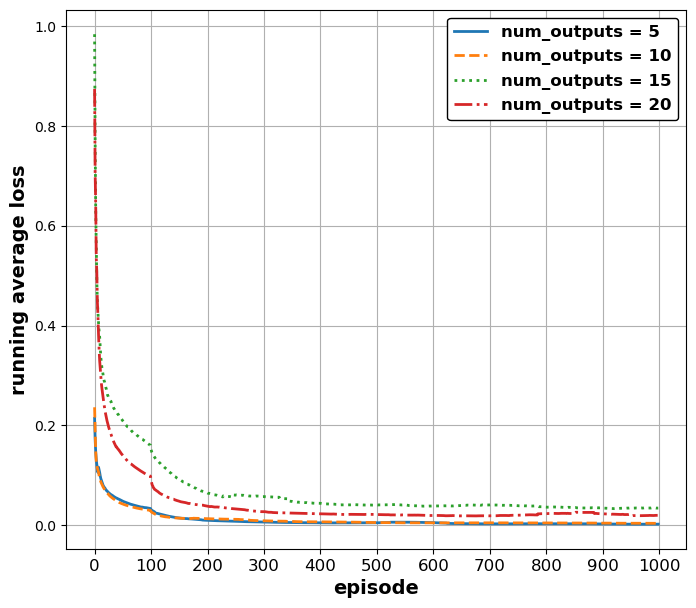

In [171]:
ax = plot_history(History[0], metric='loss', m_averages=100)
lower = min(History[0]['loss'])
linestyles = ['--', ':', '-.'] #, '-']
markers = [None, None, None, '.']
for i, history in enumerate(History[1:]):
    ax = plot_history(history, metric='loss', m_averages=100, ax=ax, 
                      linestyle=linestyles[i], marker=markers[i])
    lower = min(lower, min(history['loss']))
# ax.set_ylim([lower, 200])
ax.legend([f'num_outputs = {n}' for n in nactions], 
          prop={'weight':'bold','size':12}, edgecolor='k', framealpha=1)
ax.set_xticks(np.arange(0,1001, 100))
# ax.set_yticks(np.arange(0,201, 25))
ax.set_xlabel(ax.get_xlabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':12})
# ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':12})

plt.show()

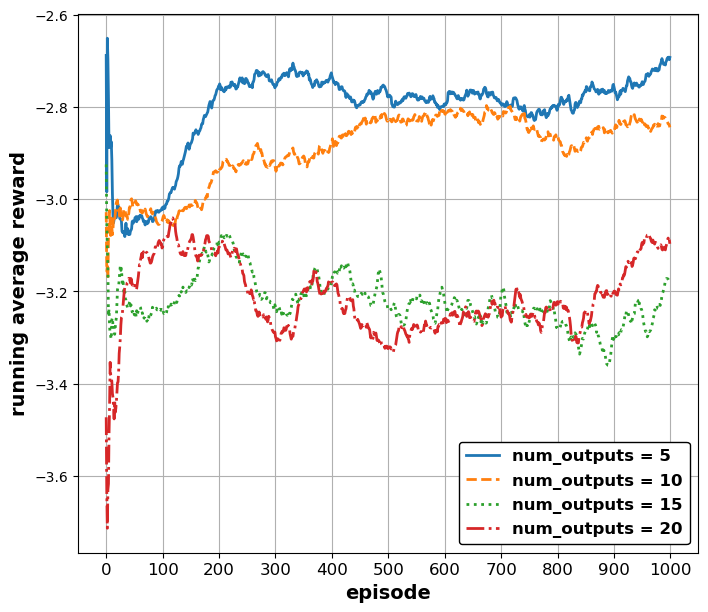

In [172]:
ax = plot_history(History[0], metric='reward', m_averages=100)
for i, history in enumerate(History[1:]):
    ax = plot_history(history, metric='reward', m_averages=100, ax=ax, 
                      linestyle=linestyles[i], marker=markers[i])
    
ax.legend([f'num_outputs = {n}' for n in nactions], 
          prop={'weight':'bold','size':12}, edgecolor='k', framealpha=1)
ax.set_xticks(np.arange(0,1001, 100))
# ax.set_yticks(np.arange(0,101, 20))
ax.set_xlabel(ax.get_xlabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':12})
# ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':12})
plt.show()

## 3. Plot training loss and rewards for different target networks (varying $\tau$ values)

### Upload data

In [178]:
History = []
tau = [0.001, 0.005, 0.01, 0.05] #, 1]
for t in tau:
    n = str(t).split('.')[-1]
    file = join(DATA_DIR, f'tau{n}/history.pickle')
    history = np.load(file, allow_pickle=True)
    History.append(history)

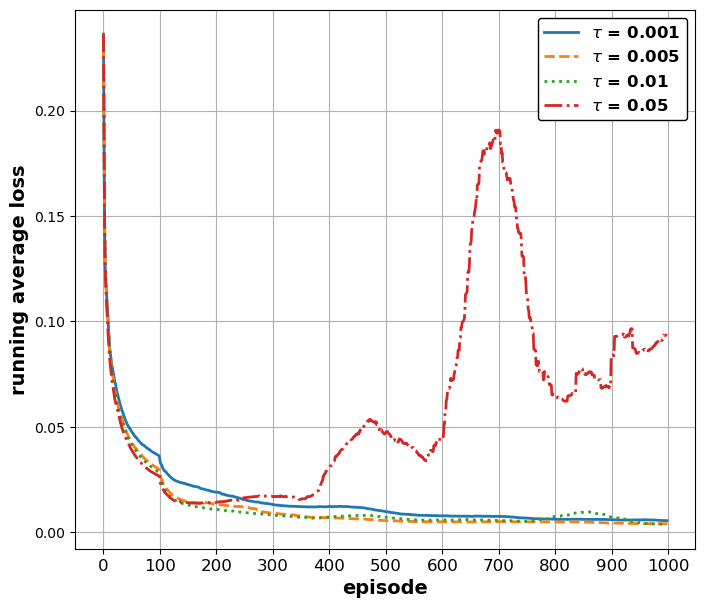

In [179]:
ax = plot_history(History[0], metric='loss', m_averages=100)
lower = min(History[0]['loss'])
linestyles = ['--', ':', '-.']#, '-']
markers = [None, None, None]#, '.']
for i, history in enumerate(History[1:]):
    ax = plot_history(history, metric='loss', m_averages=100, ax=ax, 
                      linestyle=linestyles[i], marker=markers[i])
    # lower = min(lower, min(history['loss']))
# ax.set_ylim([lower, 200])
ax.legend([rf'$\tau$ = {t}' for t in tau], 
          prop={'weight':'bold','size':12}, edgecolor='k', framealpha=1)
ax.set_xticks(np.arange(0,1001, 100))
# ax.set_yticks(np.arange(0,201, 25))
ax.set_xlabel(ax.get_xlabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':12})
# ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':12})

plt.show()

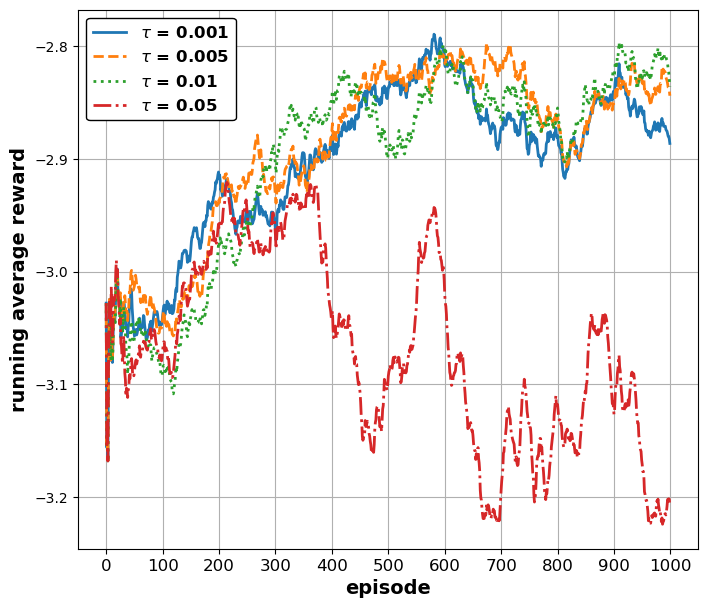

: 

In [180]:
ax = plot_history(History[0], metric='reward', m_averages=100)
for i, history in enumerate(History[1:]):
    ax = plot_history(history, metric='reward', m_averages=100, ax=ax, 
                      linestyle=linestyles[i], marker=markers[i])
    
ax.legend([rf'$\tau$ = {t}' for t in tau], 
          prop={'weight':'bold','size':12}, edgecolor='k', framealpha=1)
ax.set_xticks(np.arange(0,1001, 100))
# ax.set_yticks(np.arange(0,101, 20))
ax.set_xlabel(ax.get_xlabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'size':14, 'weight':'semibold'})
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':12})
# ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':12})
plt.show()